In [ ]:


from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Fruit/ytest/fruits-360.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Apple Red Delicious/r_116_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_117_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_118_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_119_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_120_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_121_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_122_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_123_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_124_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_125_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_126_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_127_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious/r_128_100.jpg  
  inflating: fruits-360/Training/Apple Red Delicious

mount toi project cua minh tao trong gg drive

su dung API cua kaggle

b2 : import cac thu vien can thiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

b3: load data

In [ ]:
# Loading data and putting them into training and test sets

#locations setting for training and test datasets
train_data='/content/fruits-360/Training'
test_data='/content/fruits-360/Test'

#creates X_train and Y_train using file_names and folders
def get_data(path):
    data = load_files(path)
    
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels,data['target']

X_train, Y_train, labels,data_target = get_data(train_data)
X_test, Y_test,_,_ = get_data(test_data)

In [ ]:
train = labels[Y_train]
test = labels[Y_test]

df1 = pd.DataFrame({'Train':train})
df2 = pd.DataFrame({'Test':test})

df1 = df1['Train'].value_counts().rename_axis('category').reset_index(name='train')
df2 = df2['Test'].value_counts().rename_axis('category').reset_index(name='test')
df = pd.merge(df1,df2,on='category')
df = df.sort_values(by='category').reset_index(drop=True)
df

,category,train,test
0,Apple Braeburn,492,164
1,Apple Golden 3,481,161
2,Apple Granny Smith,492,164
3,Apple Red 1,492,164
4,Apple Red 2,492,164
5,Apple Red 3,429,144
6,Apple Red Delicious,490,166
7,Cherry 1,492,164
8,Cherry 2,738,246
9,Cherry Rainier,738,246


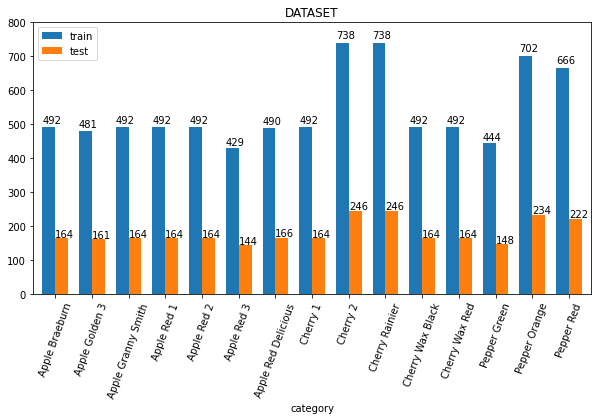

In [ ]:
ax = df.plot.bar(x='category', rot = 70, title = "DATASET", figsize=(10,5),width=0.7)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()*1.02))
plt.ylim(top=800)
plt.savefig('/content/gdrive/MyDrive/Fruit/ytest/dataset.png', dpi=300, bbox_inches="tight")

b4: gan cac bien tuong ung

In [ ]:

Y_train = np_utils.to_categorical(Y_train, 15) # la so category
Y_test = np_utils.to_categorical(Y_test, 15)

In [ ]:
Y_test.shape

(2715, 15)

In [ ]:
X_test.shape

(2715,)

In [ ]:
Y_train.shape

(8132, 15)

In [ ]:
# splitting train set into training and validation sets

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=33)
Y_train, Y_val = train_test_split(Y_train, test_size=0.2, random_state=33)


b5: convert anh sang array numpy

In [ ]:
#converting images into array to start computation

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

X_train = np.array(convert_image_to_array(X_train))
X_val = np.array(convert_image_to_array(X_val))
X_test = np.array(convert_image_to_array(X_test))

b6: chia cho 255 de cac pixel rgb chuyen ve dang [0,1]

In [ ]:
#nomalizing the pixel values before feeding into a neural network

X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255


**b7: tiep can bang CNN (Appoarch 1)**

Now, let us start with our first approach that is using a customized Convolutional Neural Networks. CNNs are amazing techniques that helps a neural network learn spatial and related features. Before CNNs came, spatial information was tough to get learnt into a neural network since all the data was fed in a flatten format. CNNs helps neural network to learn the relationships between varios areas of an image like Edges, eyes etc. The more futher deep the neural networl goes, the more complex features are learnt.

Here, as approach 1, we will use 2 X 2 filters and increase the number of layers the deeper we go along with 2 X 2 maxpooling layer which chooses the maximum value at a certain area.

We will use RELU activation function to remove linearity to learn complex features.

We will use dropout regularization which chooses a node using a probability that we will define and it will help prevent overfitting the model.

Finally, a softmax unit will be used to classify and find the loss function.

In [ ]:
#Building model 1 using customized convolutional and pooling layers

model = Sequential()

#input_shape is 100*100 since thats the dimension of each of the fruit images
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(100,100,3),padding='same')) #3 day la 3 cua rgb
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

# specifying parameters for fully connected layer
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(15,activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 16)      208       
_________________________________________________________________
activation_2 (Activation)    (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)       

b8: cai dat ham optimzer

In [ ]:
#importing ootimizers

from keras.optimizers import SGD, Adam, RMSprop

optimizer = Adam()
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

b9: dung batch_size 30 va epoches la 25 tuc la luyen 1 lan 128 buc anh va lam 

1.   List item
2.   List item

25 lan nhu vay

In [ ]:
# creating a file to save the trained CNN model 
checkpointer = ModelCheckpoint(filepath = '/content/fruits.hdf5', verbose = 1, save_best_only = True)

# fitting model using above defined layers 
CNN_model = model.fit(X_train,Y_train, batch_size = 30,
                      epochs=30, 
                      validation_data=(X_val, Y_val),
                      callbacks = [checkpointer],
                      verbose=1,
                      shuffle=True)

Epoch 1/30
217/217 [==============================] - 7s 24ms/step - loss: 1.4992 - accuracy: 0.4964 - val_loss: 0.0683 - val_accuracy: 0.9859

Epoch 00001: val_loss improved from inf to 0.06834, saving model to /content/fruits.hdf5
Epoch 2/30
217/217 [==============================] - 4s 18ms/step - loss: 0.1426 - accuracy: 0.9494 - val_loss: 0.0236 - val_accuracy: 0.9920

Epoch 00002: val_loss improved from 0.06834 to 0.02355, saving model to /content/fruits.hdf5
Epoch 3/30
217/217 [==============================] - 4s 17ms/step - loss: 0.0657 - accuracy: 0.9781 - val_loss: 0.0128 - val_accuracy: 0.9982

Epoch 00003: val_loss improved from 0.02355 to 0.01282, saving model to /content/fruits.hdf5
Epoch 4/30
217/217 [==============================] - 4s 17ms/step - loss: 0.0439 - accuracy: 0.9846 - val_loss: 0.0013 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.01282 to 0.00135, saving model to /content/fruits.hdf5
Epoch 5/30
217/217 [==============================] - 4s

b10 : load lai file vua luu

In [ ]:

#loading saved weights to use further

model.load_weights('/content/fruits.hdf5')

b11: check the accuracy

In [ ]:

#checking traing accuracy

score = model.evaluate(X_train, Y_train)
print('Train accuracy:', score[1])

204/204 [==============================] - 1s 5ms/step - loss: 5.1758e-05 - accuracy: 1.0000
Train accuracy: 1.0


In [ ]:

#checking testset accuracy

score = model.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

85/85 [==============================] - 0s 5ms/step - loss: 0.0172 - accuracy: 0.9923
Test accuracy: 0.9922651648521423


b12: predict data in test

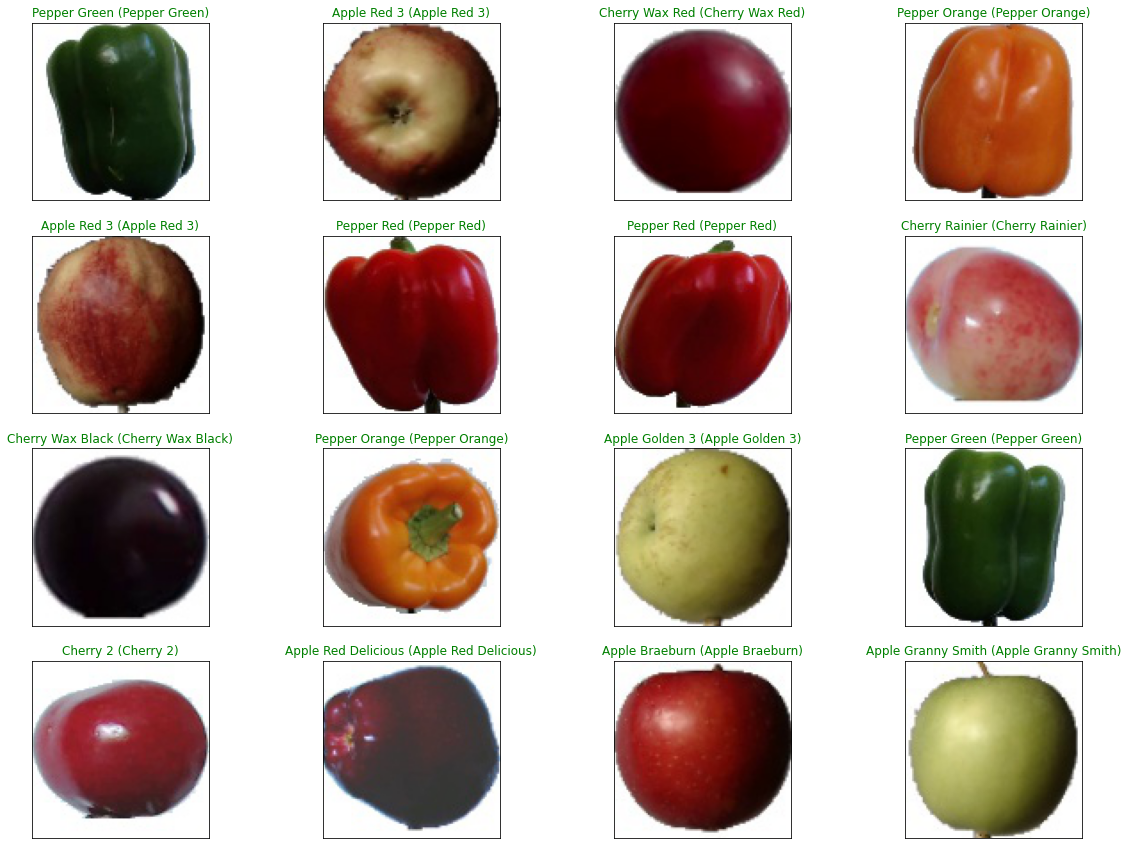

In [ ]:
# using model to predict on test data
Y_pred = model.predict(X_test)

# Lets plot the predictions of different fruits and check their original labels

fig = plt.figure(figsize=(20, 15))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(Y_pred[idx])
    true_idx = np.argmax(Y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

b13: xem sự thay đổi của loss function change the accurancy train for 25 epoches

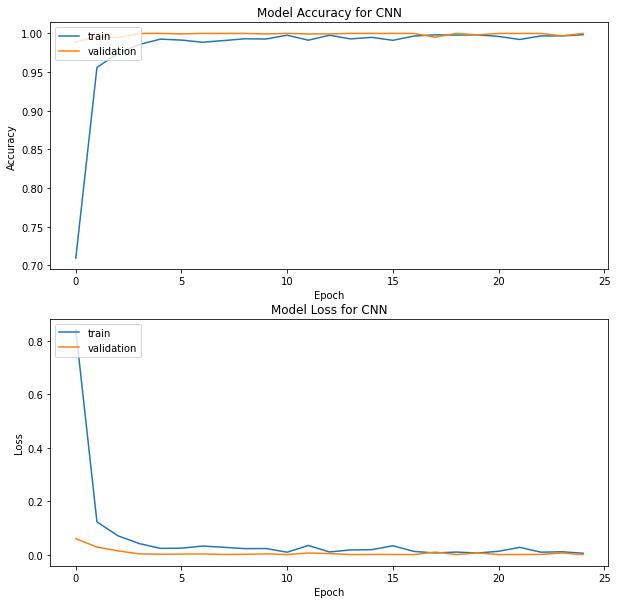

In [ ]:

#plotting the loss function and accuracy for different epochs

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(CNN_model.history['accuracy'])  
plt.plot(CNN_model.history['val_accuracy'])  
plt.title('Model Accuracy for CNN')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(CNN_model.history['loss'])  
plt.plot(CNN_model.history['val_loss'])  
plt.title('Model Loss for CNN')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')  

plt.savefig('/content/gdrive/MyDrive/Fruit/ytest/acc_CNN.png', dpi=300, bbox_inches="tight")


confuse matrix


Normalized confusion matrix
[[0.95 0.   0.   0.   0.05 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.04 0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.97 0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.  

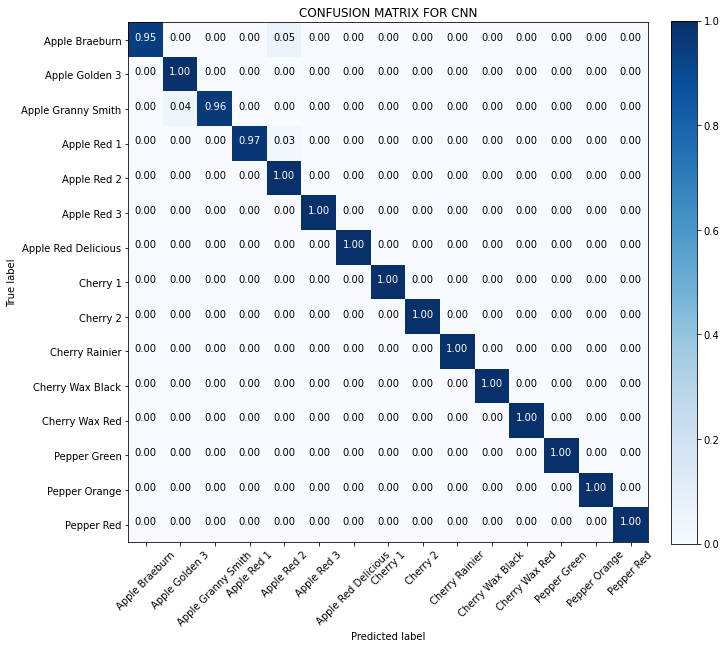

In [ ]:

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm =confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(Y_pred,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))
#plt.figure()
plot_confusion_matrix(cm, classes=labels,normalize=True,
                      title='CONFUSION MATRIX FOR CNN')

plt.savefig('/content/gdrive/MyDrive/Fruit/ytest/confuseMatrix_CNN.png', dpi=300, bbox_inches="tight")

**appoarch 2: VGG 16 transfer learning**

In [ ]:

#importing vgg16

#Part 2 using transfer learning

#importing vgg16 architecture which is trained on Imagenet

from keras.applications.vgg16 import VGG16

vgg_model = VGG16(input_shape=[100,100,3], weights='imagenet', include_top=False)

In [ ]:

#We will not train the layers imported.

for layer in vgg_model.layers:
   layer.trainable = False

In [ ]:
#summary of the imported vgg model

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
#adding some layers to the vgg_model imported and again fitting the model to check the performance

transfer_learning_model = Sequential()
 
transfer_learning_model.add(vgg_model)


transfer_learning_model.add(Conv2D(1024, kernel_size=3, padding='same'))

transfer_learning_model.add(Activation('relu'))

transfer_learning_model.add(MaxPooling2D(pool_size=(2, 2)))
transfer_learning_model.add(Dropout(0.3))

transfer_learning_model.add(Flatten())
transfer_learning_model.add(Dense(150))
transfer_learning_model.add(Activation('relu'))
transfer_learning_model.add(Dropout(0.4))
transfer_learning_model.add(Dense(15,activation = 'softmax'))
transfer_learning_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 1024)        4719616   
_________________________________________________________________
activation_12 (Activation)   (None, 3, 3, 1024)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 1, 1024)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 150)              

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop

optimizer = Adam()
transfer_learning_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:

#fitting the new model


checkpointer = ModelCheckpoint(filepath = 'transfer_learning.hdf5', verbose = 1, save_best_only = True)

# running 
transfer_learning_cnn = transfer_learning_model.fit(X_train,Y_train,
        batch_size = 30,
        epochs=25,
        validation_data=(X_val, Y_val),
        callbacks = [checkpointer],
        verbose=1, shuffle=True)

Epoch 1/25
217/217 [==============================] - 12s 50ms/step - loss: 1.4480 - accuracy: 0.5355 - val_loss: 0.0307 - val_accuracy: 0.9963

Epoch 00001: val_loss improved from inf to 0.03072, saving model to transfer_learning.hdf5
Epoch 2/25
217/217 [==============================] - 11s 49ms/step - loss: 0.0871 - accuracy: 0.9763 - val_loss: 0.0059 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.03072 to 0.00590, saving model to transfer_learning.hdf5
Epoch 3/25
217/217 [==============================] - 10s 48ms/step - loss: 0.0362 - accuracy: 0.9898 - val_loss: 0.0090 - val_accuracy: 0.9982

Epoch 00003: val_loss did not improve from 0.00590
Epoch 4/25
217/217 [==============================] - 10s 46ms/step - loss: 0.0272 - accuracy: 0.9921 - val_loss: 0.0020 - val_accuracy: 0.9994

Epoch 00004: val_loss improved from 0.00590 to 0.00195, saving model to transfer_learning.hdf5
Epoch 5/25
217/217 [==============================] - 10s 45ms/step - loss: 0.0175 - acc

In [ ]:
transfer_learning_model.load_weights('transfer_learning.hdf5')


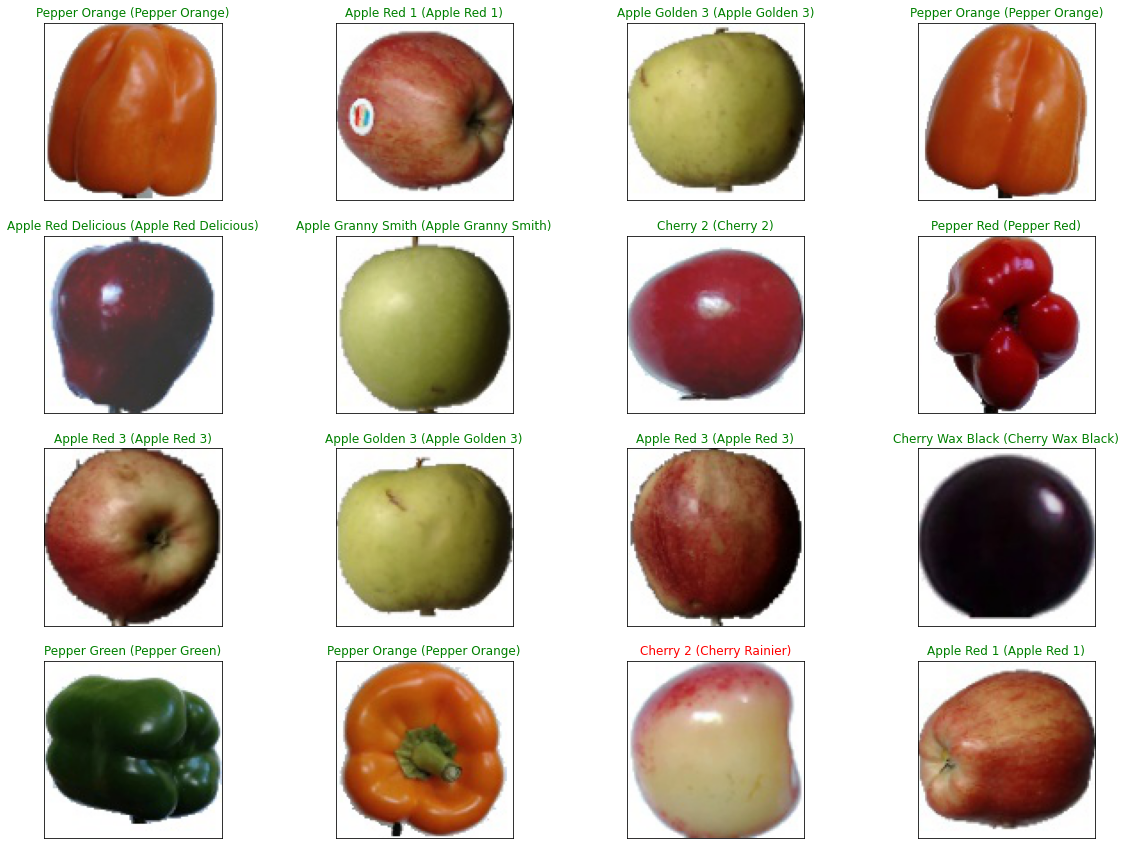

In [ ]:

# using model to predict on test data
Y_pred = transfer_learning_model.predict(X_test)

fig = plt.figure(figsize=(20, 15))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[idx])
    pred_idx = np.argmax(Y_pred[idx])
    true_idx = np.argmax(Y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [ ]:
score = transfer_learning_model.evaluate(X_train, Y_train)
print('Train accuracy:', score[1])

204/204 [==============================] - 7s 35ms/step - loss: 2.5929e-07 - accuracy: 1.0000
Train accuracy: 1.0


In [ ]:
score = transfer_learning_model.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

85/85 [==============================] - 3s 34ms/step - loss: 0.1005 - accuracy: 0.9746
Test accuracy: 0.9745856523513794


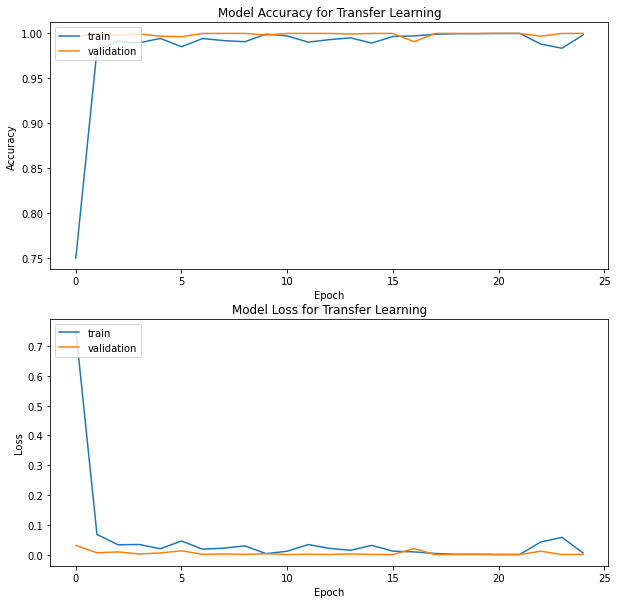

In [ ]:
#plotting curves for the transfer learning model

plt.figure(1, figsize = (10, 10))  
plt.subplot(211)  
plt.plot(transfer_learning_cnn.history['accuracy'])  
plt.plot(transfer_learning_cnn.history['val_accuracy'])  
plt.title('Model Accuracy for Transfer Learning')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')   

# plotting model loss 
plt.subplot(212)  
plt.plot(transfer_learning_cnn.history['loss'])  
plt.plot(transfer_learning_cnn.history['val_loss'])  
plt.title('Model Loss for Transfer Learning')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation'], loc='upper left')  

plt.savefig('/content/gdrive/MyDrive/Fruit/ytest/acc_TF.png', dpi=300, bbox_inches="tight")

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.19 0.81 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.01 0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.06 0.92 0.   0.   0.   0.02
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.

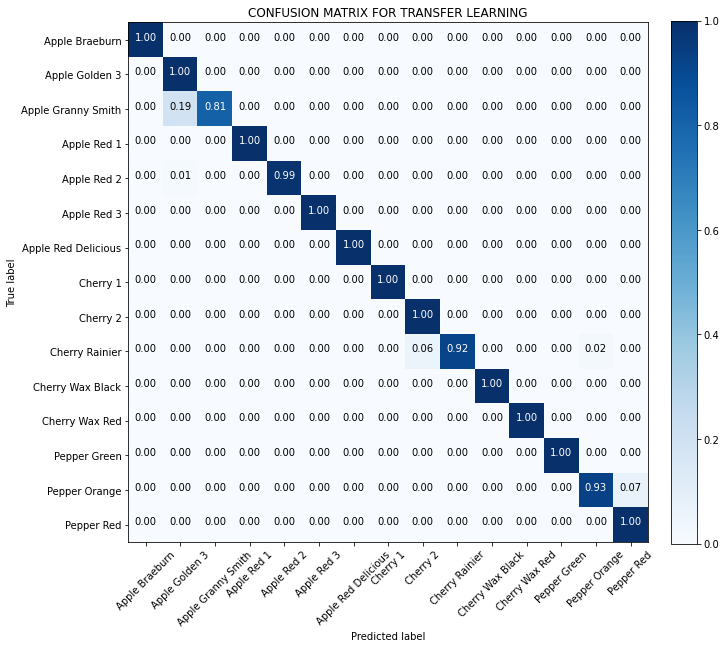

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm =confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(Y_pred,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))
#plt.figure()
plot_confusion_matrix(cm, classes=labels,normalize=True,
                      title='CONFUSION MATRIX FOR TRANSFER LEARNING')

plt.savefig('/content/gdrive/MyDrive/Fruit/ytest/confuseMatrix_TF.png', dpi=300, bbox_inches="tight")